In [1]:
from train import *
import matplotlib.pyplot as plt
import keras.backend as K
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from utils import dice_coef

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## initial model

### constructor

In [ ]:
trainer = Trainer()

In [ ]:
trainer.params.dict

In [ ]:
trainer.data_dir, trainer.experiment_dir

In [ ]:
dataset = trainer.dataset

In [ ]:
dataset.image_data.shape

In [ ]:
model = trainer.model

In [ ]:
model.summary()

### train

In [ ]:
trainer = Trainer()    

In [ ]:
trainer.train()

### predict

In [ ]:
trainer = Trainer()

In [ ]:
trainer.pred_file

In [ ]:
trainer.dataset.load_data_test()

In [ ]:
trainer.dataset.image_data_test.shape

In [ ]:
plt.imshow(trainer.dataset.image_data_test[0].reshape(512, 512), cmap='gray')

In [ ]:
test_masks = trainer.model.predict(trainer.dataset.image_data_test)

## custom metrics

### get predictions

First of all we may see that `val_pixel_diff` shows no signs of overfitting. Is it even correct?

![val_accuracy](images/01-val_accuracy.png)
![val_pixel_diff](images/02-val_pixel_diff.png)

In [2]:
trainer = Trainer()

In [3]:
img_arr = trainer.dataset.image_data[0]
mask_arr = trainer.dataset.mask_data[0]

In [48]:
weight_file = 'experiments/initial_model/weights.10-0.91.hdf5'
mask_pred_10 = trainer.predict_image(img_arr, weight_file)

In [5]:
weight_file = 'experiments/initial_model/weights.30-0.91.hdf5'
mask_pred_30 = trainer.predict_image(img_arr, weight_file)

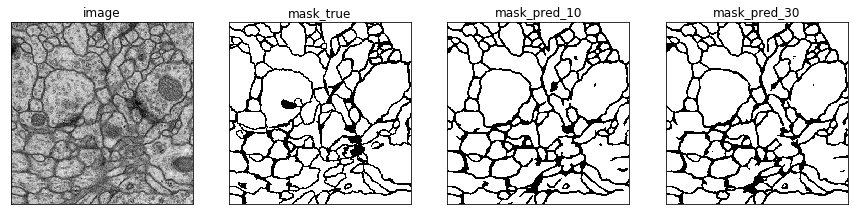

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(15, 15))
[axi.set_xticks([]) for axi in ax.ravel()]
[axi.set_yticks([]) for axi in ax.ravel()]
ax[0].imshow(img_arr.reshape(512, 512), cmap='gray');
ax[1].imshow(mask_arr.reshape(512, 512), cmap='gray');
ax[2].imshow(mask_pred_10.reshape(512, 512), cmap='gray');
ax[3].imshow(mask_pred_30.reshape(512, 512), cmap='gray');
ax[0].title.set_text('image')
ax[1].title.set_text('mask_true')
ax[2].title.set_text('mask_pred_10')
ax[3].title.set_text('mask_pred_30')

In [7]:
mask_pred_10.shape

(512, 512, 1)

In [8]:
mask_pred_10[500, 500]

array([1.], dtype=float32)

In [9]:
np.sum(mask_pred_10)

203121.0

In [10]:
512 ** 2

262144

### convert metrics into int

In [11]:
mask_arr.shape, mask_pred_10.shape, mask_pred_30.shape

((512, 512, 1), (512, 512, 1), (512, 512, 1))

In [12]:
mask_arr[0, 0]

array([255.])

In [13]:
mask_arr /= 255.0 

In [14]:
mask_arr = mask_arr.round()

In [15]:
mask_arr[0, 0]

array([1.])

In [16]:
mask_arr = mask_arr.astype(np.int)

In [17]:
mask_arr[0, 0]

array([1])

In [18]:
mask_pred_10, mask_pred_30 = mask_pred_10.astype(np.int), mask_pred_30.astype(np.int)

In [19]:
mask_pred_10[0, 0]

array([1])

### compute metrics

#### accuracy

In [20]:
def get_accuracy(y_true, y_pred):
    N = y_true.shape[0] ** 2
    return np.sum(np.equal(y_true, y_pred)) / N

In [21]:
get_accuracy(mask_arr, mask_pred_10)

0.9064903259277344

In [22]:
get_accuracy(mask_arr, mask_pred_30)

0.9015922546386719

Let's check our computations with `sklearn`.

In [23]:
accuracy_score(mask_arr.reshape(-1), mask_pred_10.reshape(-1))

0.9064903259277344

#### pixel_diff

Looks like `pixel_diff` is **not** the best metric. It's more like `accuracy` - taking into account both correct 0s and 1s. Also it's not clear what we compute during the training if we're not rounding our predictions.

In [24]:
def get_pixel_diff(y_true, y_pred):
    N = y_true.shape[0] ** 2
    return np.sum(np.abs(y_true - y_pred)) / N

In [25]:
get_pixel_diff(mask_arr, mask_pred_10)

0.09350967407226562

In [26]:
get_pixel_diff(mask_arr, mask_pred_30)

0.09840774536132812

In [27]:
mask_arr.reshape(-1).shape

(262144,)

#### f1 and dice coeff.

If we compute `f1` we'll get much worse score. And we should remember that we need black color to be the same - those are 0s (not 1s which is 255 or white). 

In [28]:
precision_score(mask_arr.reshape(-1), mask_pred_10.reshape(-1), pos_label=0), \
recall_score(mask_arr.reshape(-1), mask_pred_10.reshape(-1), pos_label=0), \
f1_score(mask_arr.reshape(-1), mask_pred_10.reshape(-1), pos_label=0)

(0.7793741422835166, 0.8001287135601475, 0.7896150710208986)

In [29]:
precision_score(mask_arr.reshape(-1), mask_pred_30.reshape(-1), pos_label=0), \
recall_score(mask_arr.reshape(-1), mask_pred_30.reshape(-1), pos_label=0), \
f1_score(mask_arr.reshape(-1), mask_pred_30.reshape(-1), pos_label=0)

(0.7689709601317063, 0.7880574688652334, 0.7783972305022722)

First of all let's reproduce those results and then compute `dice_coef`. Actually as we know those metrics should be the same. And they are.

In [30]:
def dice_coef_man(y_true, y_pred, smooth=1.):
    y_true_flip = 1 - y_true
    y_pred_flip = 1 - y_pred
    intersection = np.sum(y_true_flip * y_pred_flip)
    return (2 * intersection + smooth) / (np.sum(y_true_flip) + np.sum(y_pred_flip))

In [31]:
dice_coef_man(mask_arr, mask_pred_10, smooth=0.0)

0.7896150710208986

In [32]:
dice_coef_man(mask_arr, mask_pred_30, smooth=0.0)

0.7783972305022722

What metric is used in Klibisz? He uses `dice_coef`:

```python
self.net.compile(..., loss='binary_crossentropy', metrics=[dice_coef])
```

The issue however that he doesn't flip tensors. So we maximize number of ones that represent white pixels. And we need to maximize number of correct pixels on border that are black (so equal to 0).

Here's his function:

```python
def dice_coef(y_true, y_pred):
    smooth = 1.0
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_true_flat * y_pred_flat)
    return (2.0 * intersection + smooth) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + smooth)
```

Let's try to rewrite this function using `tensorflow 2.0`.

In [33]:
x = tf.constant([0.35, 0.51, 0.3, 0.5, 0.95])

In [34]:
tf.round(x)

<tf.Tensor: id=1095, shape=(5,), dtype=float32, numpy=array([0., 1., 0., 0., 1.], dtype=float32)>

In [35]:
1 - tf.round(x)

<tf.Tensor: id=1098, shape=(5,), dtype=float32, numpy=array([1., 0., 1., 1., 0.], dtype=float32)>

Let's test this function on masks above. We may see that it computes correct `f1` score.

In [41]:
mask_arr_tensor = tf.convert_to_tensor(mask_arr, dtype=tf.float32)

In [45]:
mask_pred_10_tensor = tf.convert_to_tensor(mask_pred_10, dtype=tf.float32)

In [46]:
dice_coef(mask_arr_tensor, mask_pred_10_tensor)

tf.Tensor([1. 1. 1. ... 1. 1. 1.], shape=(262144,), dtype=float32) tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(262144,), dtype=float32)
tf.Tensor([1. 1. 1. ... 1. 1. 1.], shape=(262144,), dtype=float32) tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(262144,), dtype=float32)
tf.Tensor(0.9398858, shape=(), dtype=float32)


<tf.Tensor: id=1142, shape=(), dtype=float32, numpy=0.7896169>

In [49]:
f1_score(mask_arr.reshape(-1), mask_pred_10.reshape(-1), pos_label=0)

0.7896150710208986

In [50]:
f1_score(mask_arr.reshape(-1), mask_pred_10.reshape(-1), pos_label=1)

0.9398856716849815

### custom loss function

Should we use `cross_enropy` if we're interested in `f1` (`dice_coef`)? 